# Standard BESCA workflow

The current workflow works with the Scanpy version 1.4.


For the PBMC 3k, we loaded directly the files available on Zenodo on the 
Galaxy training network:

https://zenodo.org/record/3581213#.XtDwuzozaUk 

The standard workflow was run with few modification:

+ some changes in the filtering parameters; this dataset requires to restrict some filtering parameters

+ increasing leiden resolution.




### Import section ###

In [2]:
import besca as bc
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy import sparse, io
import os
import time
sc.logging.print_versions()

import logging
import seaborn as sns
#from sinfo import sinfo

# for standard processing, set verbosity to minimum
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)
version = '2.8'
start0 = time.time()

scanpy==1.4.6 anndata==0.7.1 umap==0.4.2 numpy==1.17.0 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.0 statsmodels==0.11.1 python-igraph==0.8.2


In [3]:
#print(bc.__file__)

## Setup Standard Wokflow

### Parameters to be set - on the command line or here ###

In [4]:
# decisions to be made
use_example_dataset = True # If True, the pipeline will run using the example dataset shipped with BESCA

species = 'human'
batch_to_correct = 'None' # must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
analysis_name = 'pbmc3k_filtered'
split_condition='experiment' #'experiment' is generally a good default
dynrange=['B2m','Actb','Pgk1','Ctcf'] #genes for which to plot dynamic range
if species=='human': dynrange=[x.upper() for x in dynrange]

#additional labeling
labeling_to_use = 'None' # must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
labeling_name = 'MyAnno' # define name under which the labeling should be exported
labeling_description = 'celltype annotation' #define description which should be saved to labeling_info file
labeling_author = 'author' #define author which should be saved to labeling info file

### Define Input ###

In [5]:
# define filepath (this is the folder that contains "raw" and "analyzed")
root_path = os.getcwd()

### Standard parameters - these should be kept as stable as possible ###

Here, threshold were lowered to fit this dataset and the Seurat tutorial. 
Those are quite loose thresholds for now.

In [6]:
# the standard parameter section
standard_min_genes = 200
standard_min_cells = 2
standard_min_counts = 1000
standard_n_genes = 2000 # this is the most tricky one to set
standard_percent_mito = 0.05
standard_max_counts = 7000 #might be redundant with n_genes

## Standard Pipeline
(note nothing below this point should be modified!!)

In [7]:
# define standardized file paths based on the input above
results_folder = os.path.join(root_path, 'analyzed', analysis_name)
results_file = os.path.join(results_folder, analysis_name + '.h5ad') # specify a .h5ad file for storing the results
log_file = os.path.join(results_folder, analysis_name + '.standard.log') # specify a log file for keeping a short summary and overview
sc.settings.figdir = os.path.join(results_folder, 'figures')

#setup standard workflow (generates output directories and setsup logging file)
bc.st.setup(results_folder, 
          analysis_name, 
          labeling_name, 
          labeling_to_use, 
          log_file, 
          version,
          root_path, 
          species, 
          batch_to_correct, 
          standard_min_genes,
          standard_min_cells,
          standard_min_counts,
          standard_n_genes,
          standard_percent_mito,
          standard_max_counts)


# Here, no metada

adata = bc.st.read_matrix(root_path, citeseq = None,  annotation = False)


LOG MESSAGE: Standard Pipeline Version 2.8 used
LOG MESSAGE: 2020-06-02
LOG MESSAGE: Analysis 'pbmc3k_filtered' on data located in'./PBMC'
LOG MESSAGE: species: human
LOG MESSAGE: Batch effect to correct: None
LOG MESSAGE: Parameters:
LOG MESSAGE: 	standard_min_genes = 200
LOG MESSAGE: 	standard_min_cells = 2
LOG MESSAGE: 	standard_min_counts = 1000
LOG MESSAGE: 	standard_n_genes = 2000
LOG MESSAGE: 	standard_max_counts = 7000
LOG MESSAGE: 	standard_percent_mito = 0.05
LOG MESSAGE: 	Time for creating all output directories and setting up logging: 0.009s


all output directories created successfully
reading matrix.mtx
adding cell barcodes
adding genes


LOG MESSAGE: After input: 2700 cells, 32738 genes
LOG MESSAGE: 	Time for reading data: 0.213s


making var_names unique
adding ENSEMBL gene ids to adata.var


This data was downloaded from an external institution it is thus possible to make sure that the format is the most-compatible to the one expected by Besca.
Besca has a small helper function for this (dev. branch for now).

In [8]:
# THIS WOULD FAIL with Exception
#Exception: Required CELL columns in observations

# bc.Import.assert_adata(adata, attempFix=False)

In [9]:
adata.obs['CELL'] = adata.obs.index
bc.Import.assert_adata(adata, attempFix=False)

AnnData object with n_obs × n_vars = 2700 × 32738 
    obs: 'CELL'
    var: 'ENSEMBL', 'SYMBOL'

In [10]:
adata 

AnnData object with n_obs × n_vars = 2700 × 32738 
    obs: 'CELL'
    var: 'ENSEMBL', 'SYMBOL'

In [11]:
adata.write_h5ad( root_path + '/raw/pbmc3k_raw.h5ad')

In [12]:
# calculate mitochondrial gene content
bc.pp.fraction_counts(adata=adata, species=species)

### Visualization of quality control plots and selected filtering parameters

#### Count occurrence

This plot shows cell counts per sample

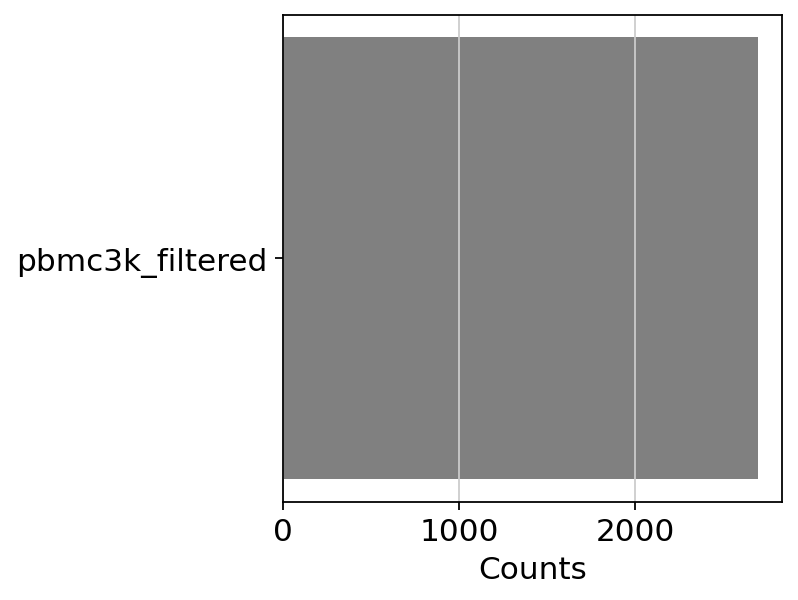

In [13]:
adata.obs['experiment'] = analysis_name

temp=bc.tl.count_occurrence(adata,split_condition)
sns.barplot(y=temp.index,x=temp.Counts,color='gray',orient='h')


#### Transcript capture efficiency

This plot gives you an idea about the sequencing depth and if the sequencing has reached saturation or not.

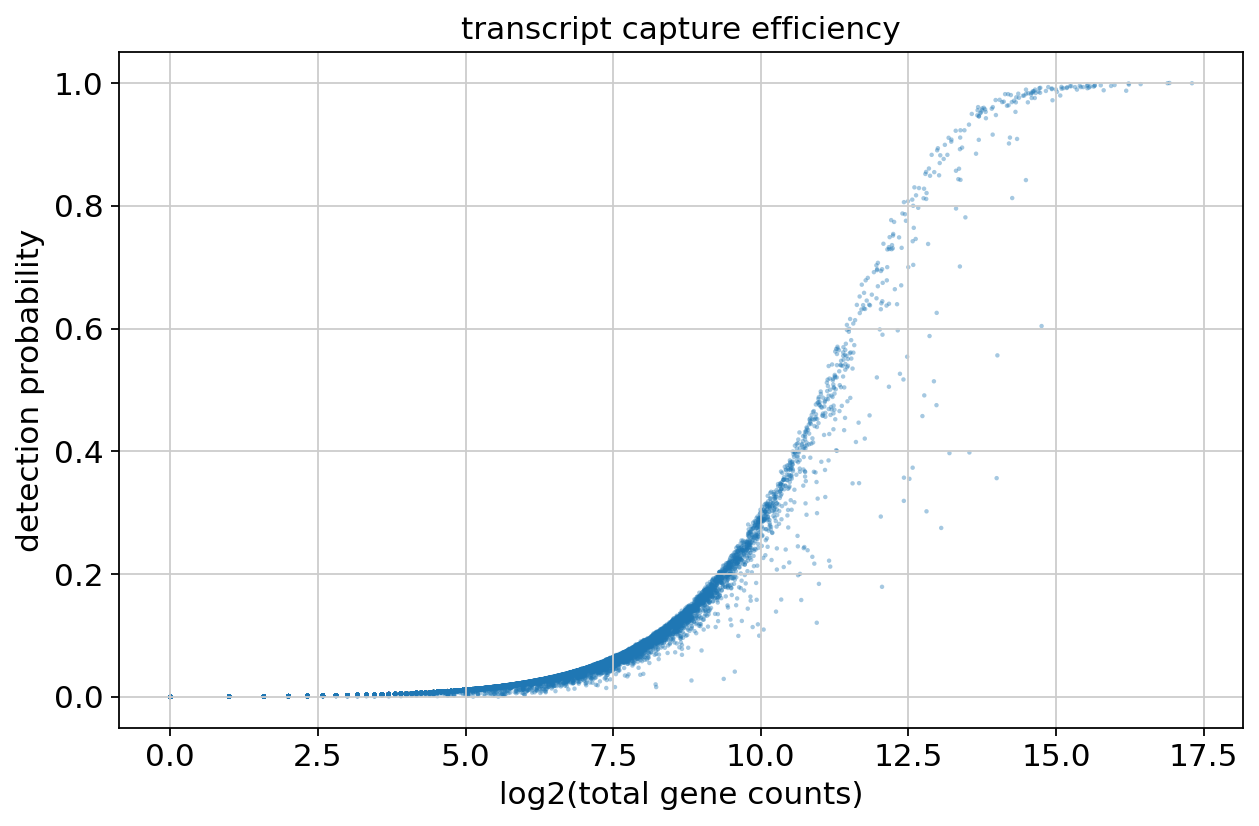

In [14]:
fig, ax = plt.subplots(1)
fig.set_figwidth(8)
fig.set_figheight(5)
fig.tight_layout()

bc.pl.transcript_capture_efficiency(adata,ax=ax)
fig.savefig(os.path.join(results_folder, 'figures/transcriptcaptureefficiency.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

#### Library size distribution

This plot gives you an idea about the library size distribution in your dataset before processing.

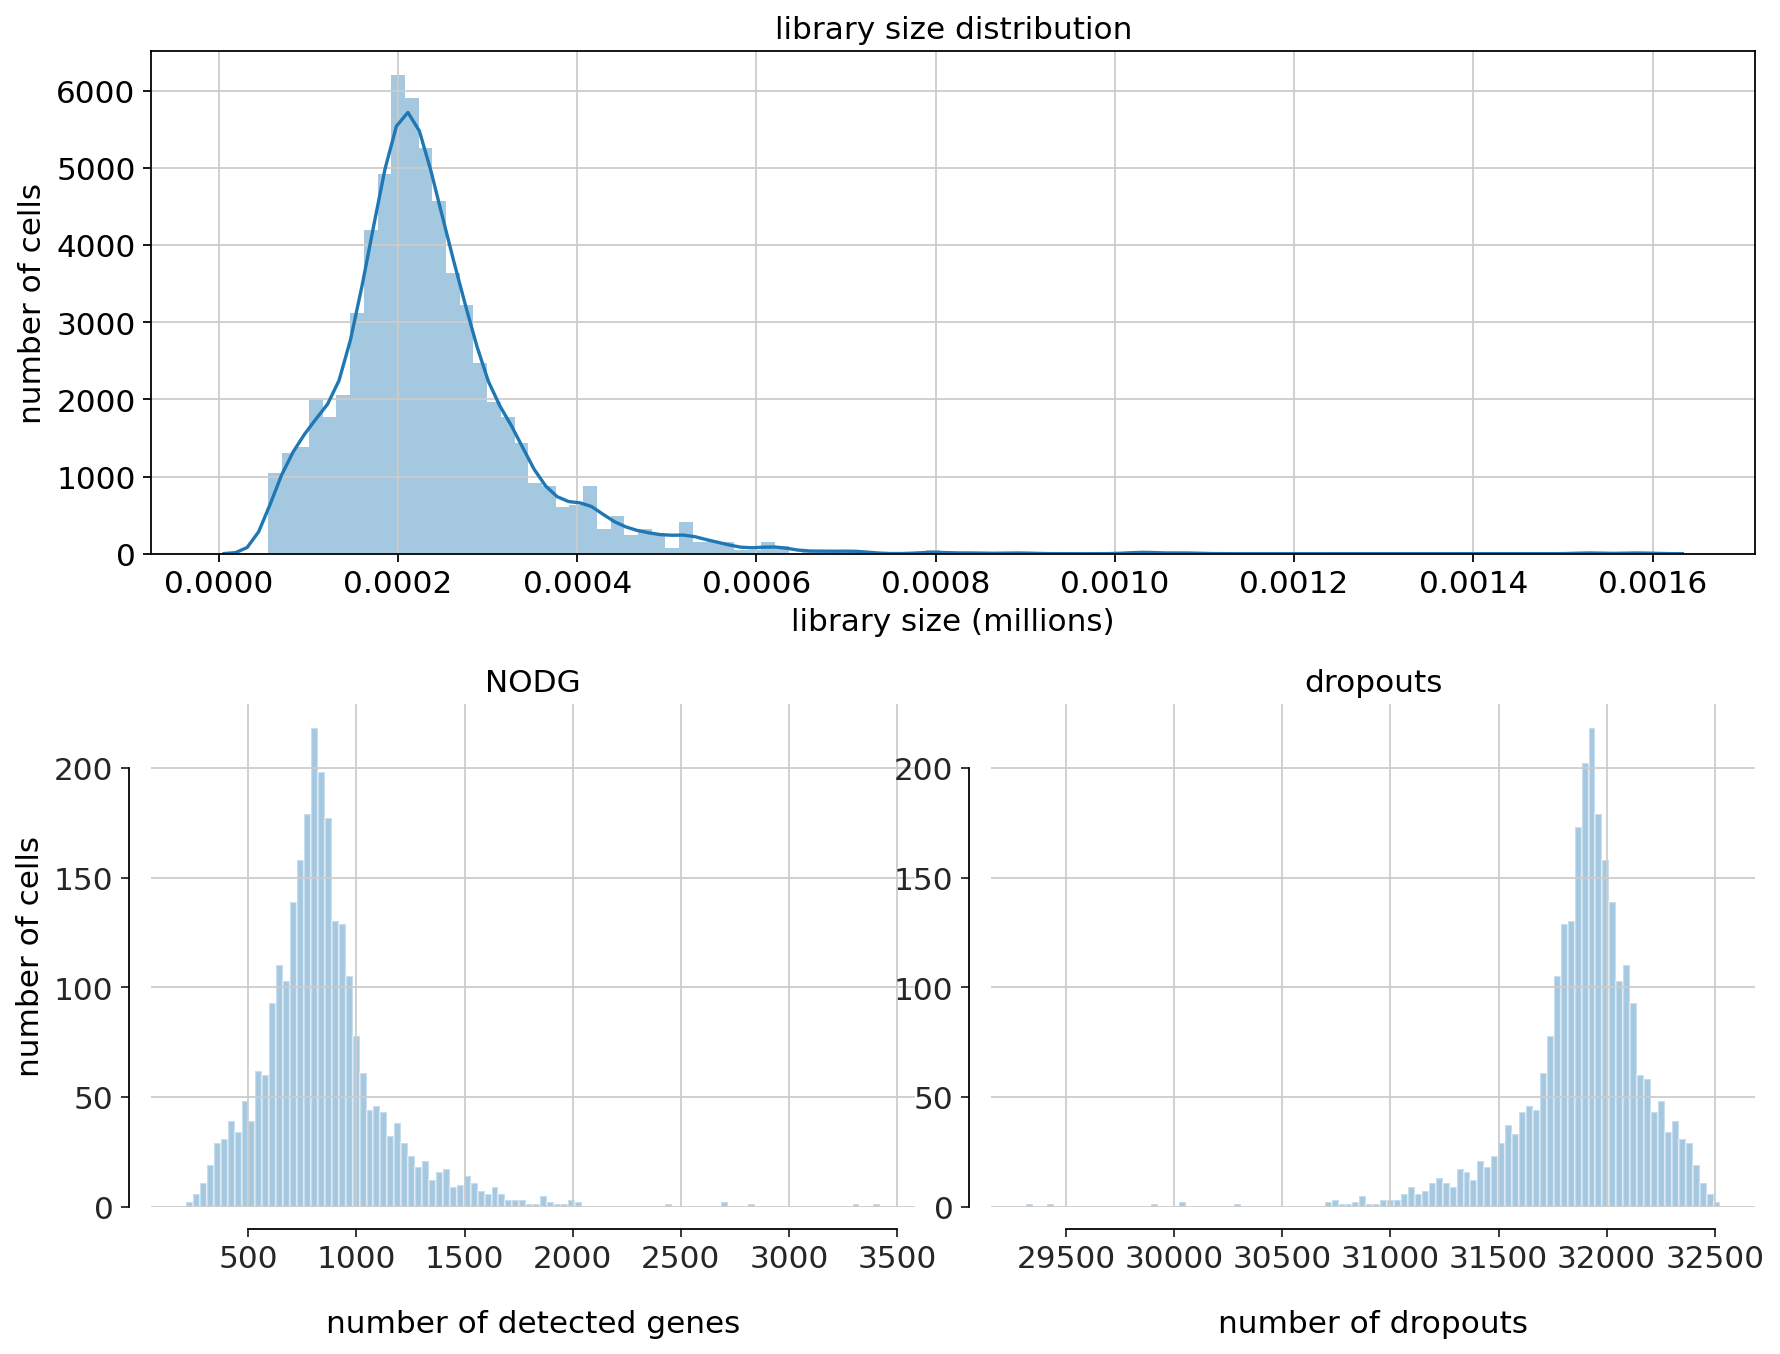

In [15]:
fig = bc.pl.librarysize_overview(adata, bins=100)
fig.savefig(os.path.join(results_folder, 'figures/librarysize.png'), format='png',bbbox_inches = 'tight') #save figure for QC report

In [16]:
adata_unfiltered = adata.copy()

#### The effect of filtering parameters

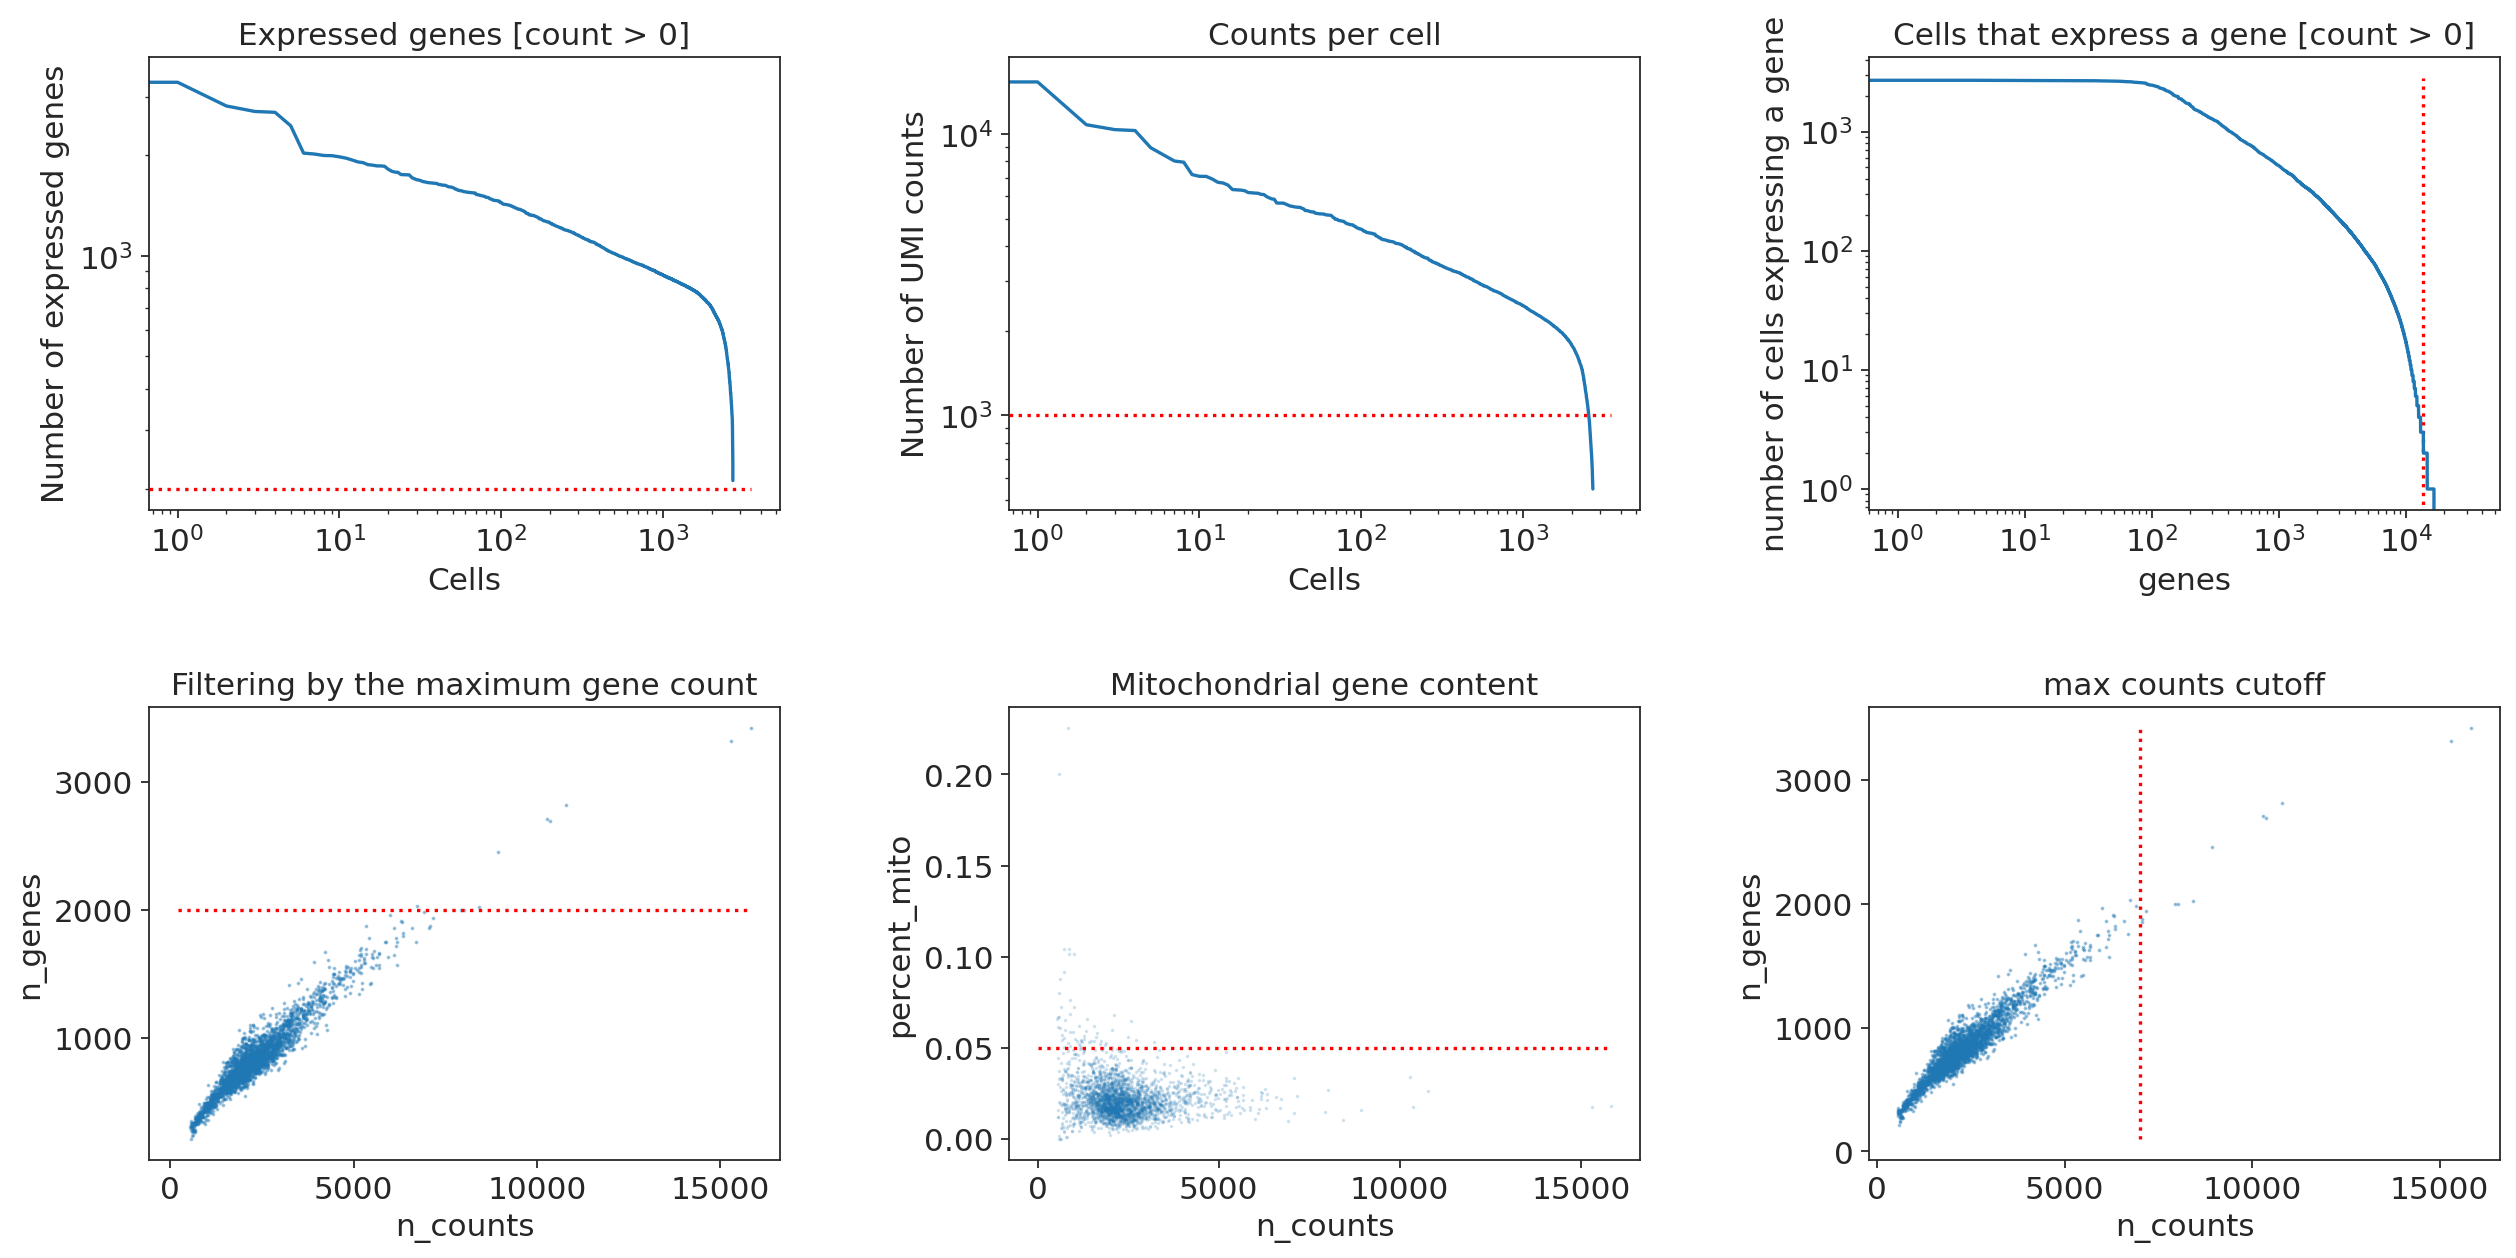

In [17]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(ncols=3, nrows=2)
fig.set_figwidth(17)
fig.set_figheight(9)
fig.tight_layout(pad=4.5)

bc.pl.kp_genes(adata, min_genes=standard_min_genes, ax = ax1)
bc.pl.kp_counts(adata, min_counts=standard_min_counts, ax = ax2)
bc.pl.kp_cells(adata, min_cells=standard_min_cells, ax = ax3)
bc.pl.max_genes(adata, max_genes=standard_n_genes, ax = ax4)
bc.pl.max_mito(adata, max_mito=standard_percent_mito, annotation_type='SYMBOL', species=species, ax = ax5)
bc.pl.max_counts(adata, max_counts=standard_max_counts, ax=ax6)
fig.savefig(os.path.join(results_folder, 'figures/filtering_thresholds.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

#### Scanpy plots of genes, counts, and mitochondria gene counts

... storing 'experiment' as categorical


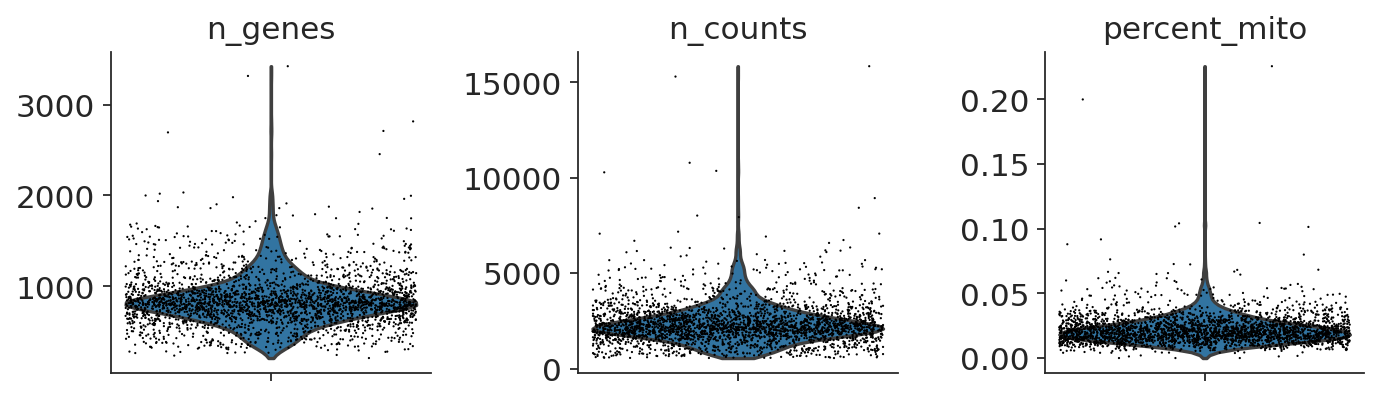

In [18]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True, save = '.before_filtering.png')

#### Mitochondrial genes, genes, and counts by samples grouped by the split condition

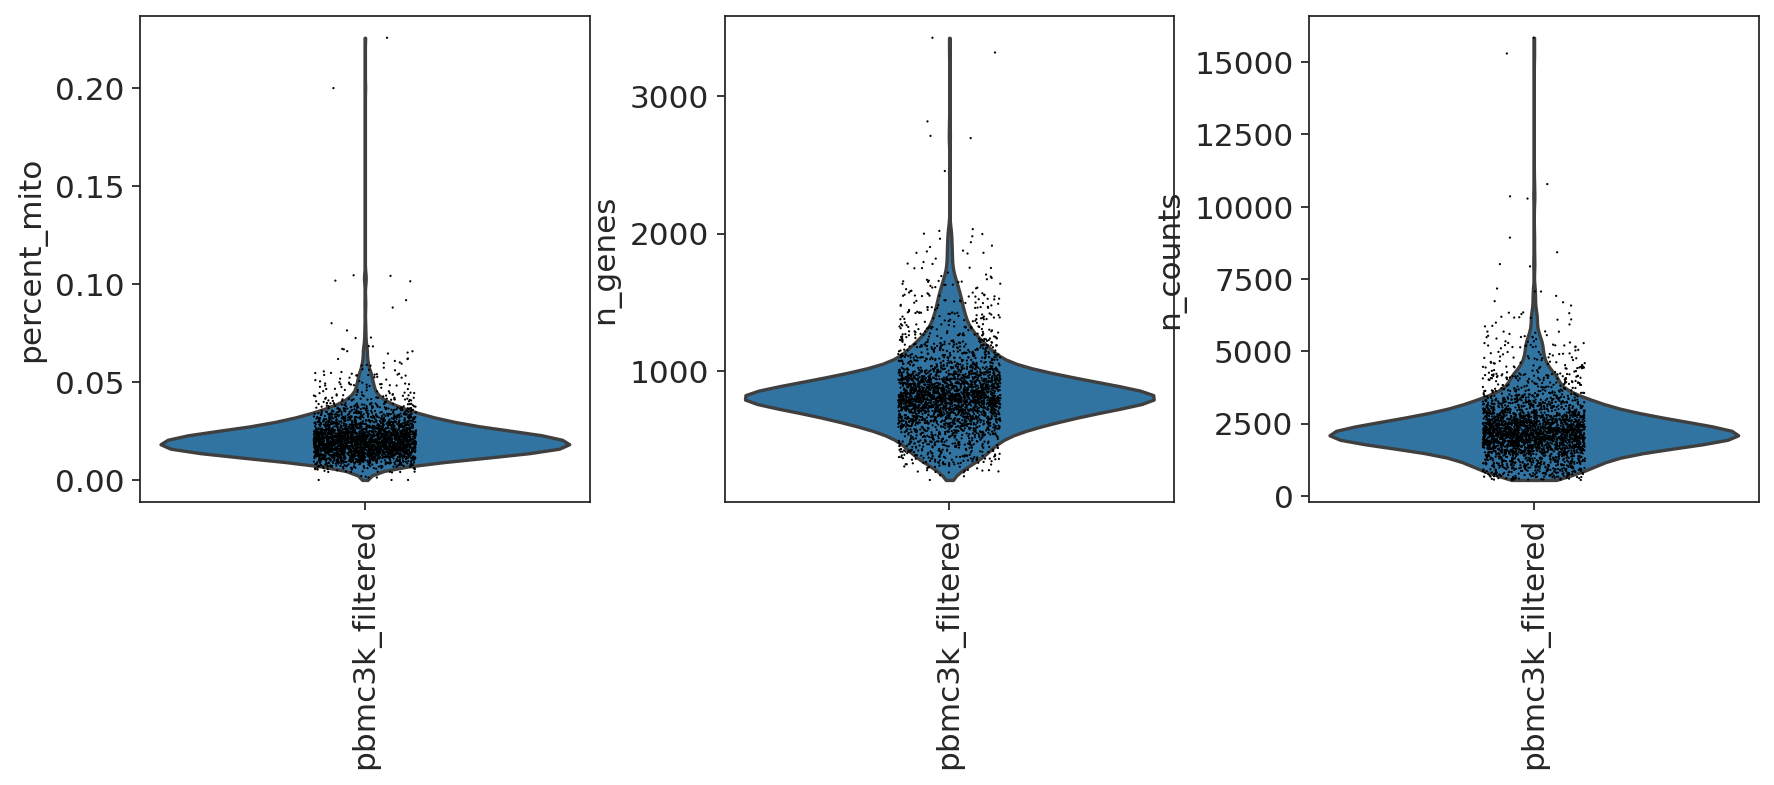

In [19]:
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'], groupby=split_condition,jitter=0.1,rotation=90, save = '.before_filtering.split.png')

### Filtering

#### Filtering with thresholds of gene and cell counts

In [20]:
%%capture filtering1
adata = bc.st.filtering_cells_genes_min(adata, standard_min_cells, standard_min_genes, standard_min_counts)

LOG MESSAGE: After filtering for minimum number of cells and minimum number of expressed genes: 2547 cells, 14702 genes
LOG MESSAGE: 	Time for filtering: 0.076s


In [21]:
filtering1.show()

started with  2700  total cells and  32738  total genes
removed 0 cells that did not express at least 200  genes
removed 153 cells that did not have at least 1000 counts
removed 18036 genes that were not expressed in at least 2 cells
finished with 2547  total cells and 14702 total genes


#### Filtering with thresholds of proportion of mitochondrial genes and the upper limit of gene counts

In [22]:
%%capture filtering2
adata = bc.st.filtering_mito_genes_max(adata, standard_percent_mito, standard_n_genes, standard_max_counts)

LOG MESSAGE: After filtering for maximum number of expressed genes and max percent mito: 2504 cells, 14702 genes
LOG MESSAGE: 	Time for filtering: 0.046s


In [23]:
filtering2.show()

started with  2547  total cells and  14702  total genes
removed 8 cells that expressed more than 2000 genes
removed 5 cells that had more than 7000  counts
removed  30  cells that expressed  5.0 percent mitochondrial genes or more
finished with 2504  total cells and 14702 total genes


#### Visualising QC metrics of the filtered dataset

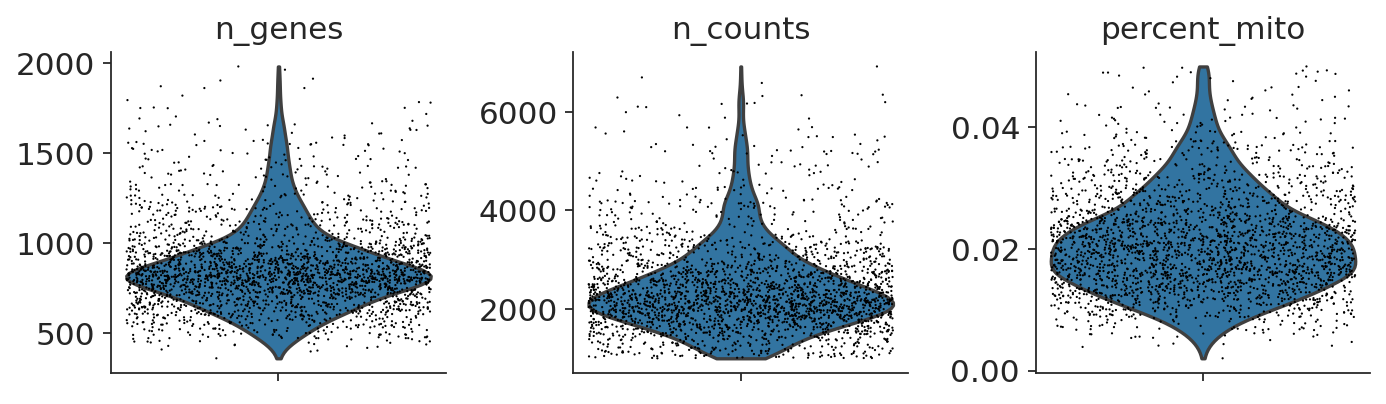

In [24]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True, save = '.after_filtering.png')

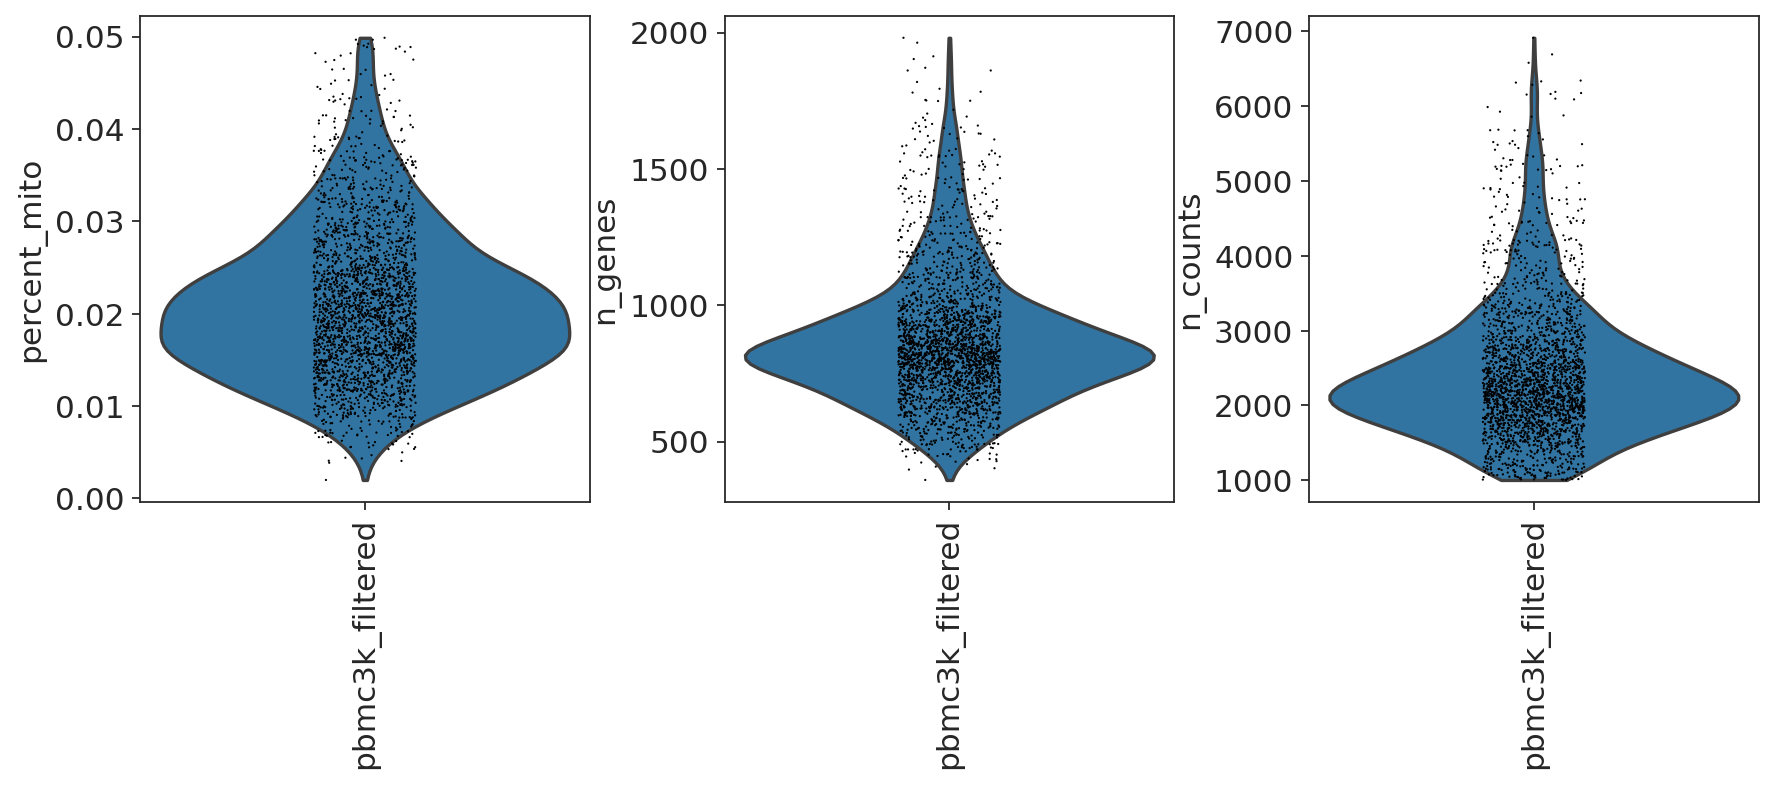

In [25]:
### check mitochondrial reads per sample 
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'], groupby=split_condition,jitter=0.1,rotation=90, save = '.after_filtering.split.png')

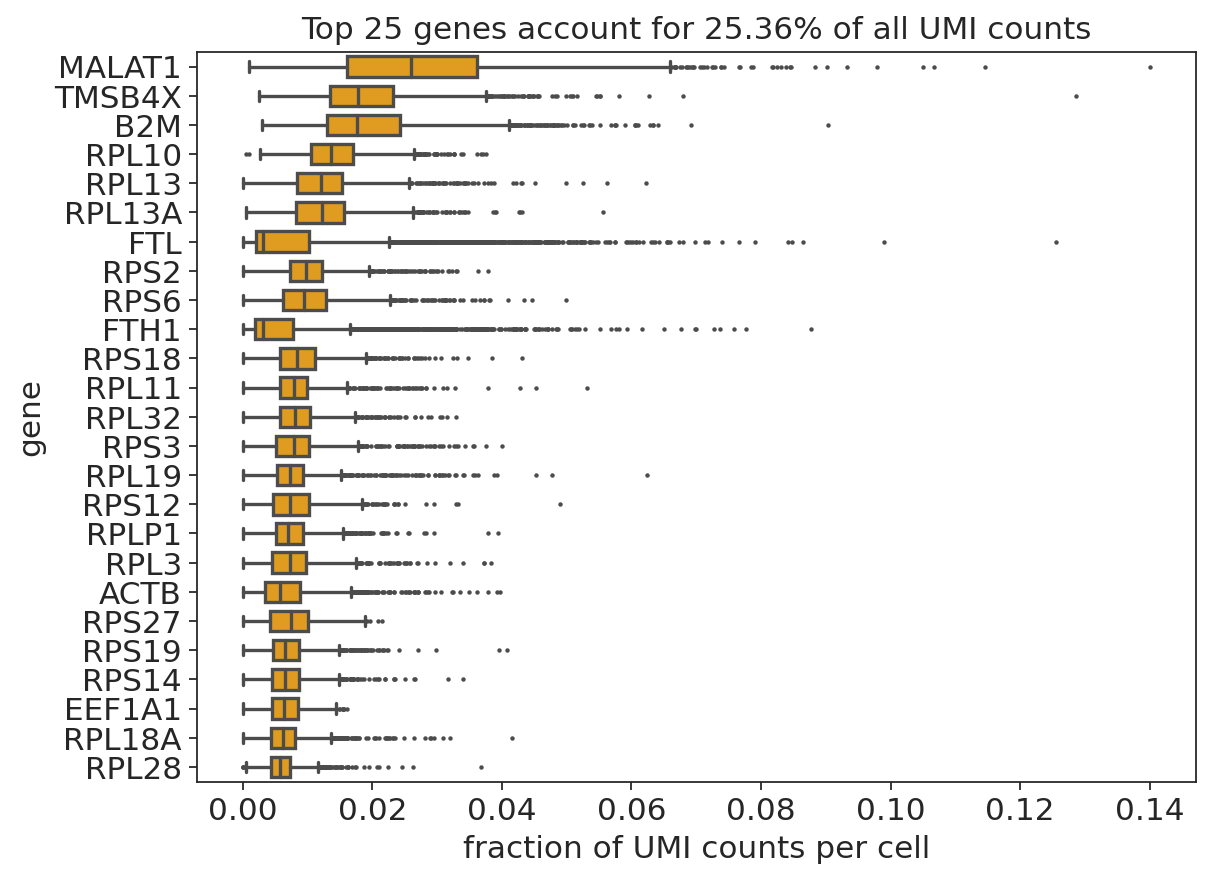

In [26]:
#display the top 25 genes in the dataset
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (8, 6))
bc.pl.top_genes_counts(adata=adata, top_n=25, ax = ax )
fig.savefig(os.path.join(results_folder, 'figures/top_genes.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

### Per-cell normalization and output of the normalized data

In [27]:
adata = bc.st.per_cell_normalize(adata, results_folder)

LOG MESSAGE: Per cell normalization completed successfully.
LOG MESSAGE: 	Time for per-cell normalization: 0.072s


adata normalized per cell
log1p values saved into adata.raw
writing out matrix.mtx ...


LOG MESSAGE: cp10k values exported to file.
LOG MESSAGE: 	Time for cp10k export: 4.262s


adata.X successfully written to matrix.mtx. 
genes successfully written out to genes.tsv
cellbarcodes successfully written out to barcodes.tsv
annotation successfully written out to metadata.tsv


We perform an additional QC, which checks the dynamic range of ubiquitously expressed marker genes.

./miniconda3/envs/besca/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.



<Figure size 320x320 with 0 Axes>

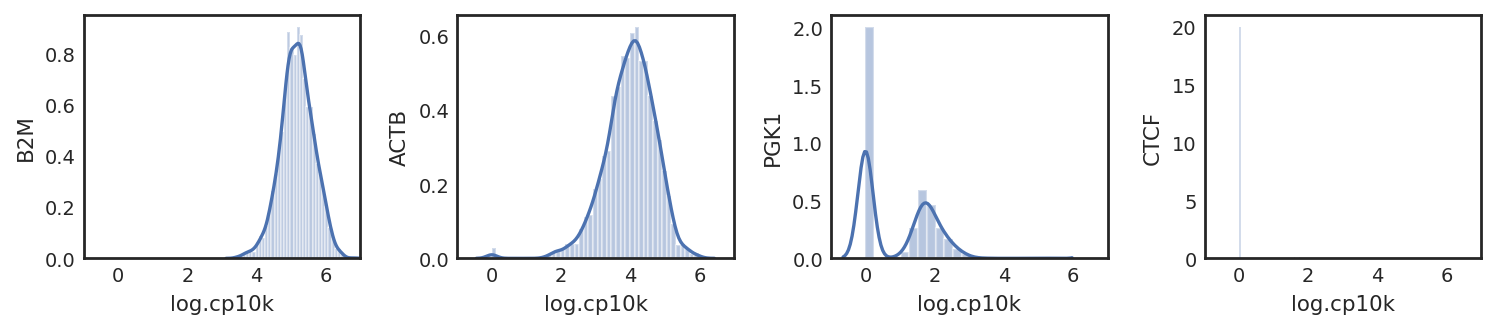

In [28]:
# Further QC: dynamic range of ubi/marker genes
fig = plt.figure()
sns.set(font_scale=0.8)
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(len(dynrange)*2.8,2))
fig.subplots_adjust(hspace=0.2, wspace=0.35)
for i in range(1,len(dynrange)+1):
    ax = fig.add_subplot(1, len(dynrange), i)
    myg=dynrange[i-1]
    try:
        g=sns.distplot(adata.raw[:,myg].X.toarray(), norm_hist=True)
        ax.set(xlabel='log.cp10k',ylabel=myg)
        g.set_xlim(-1, 7)
    except:
        print( myg + ' can not be plotted')

### Feature selection (highly variable genes) for clustering ###

log1p taken of adata


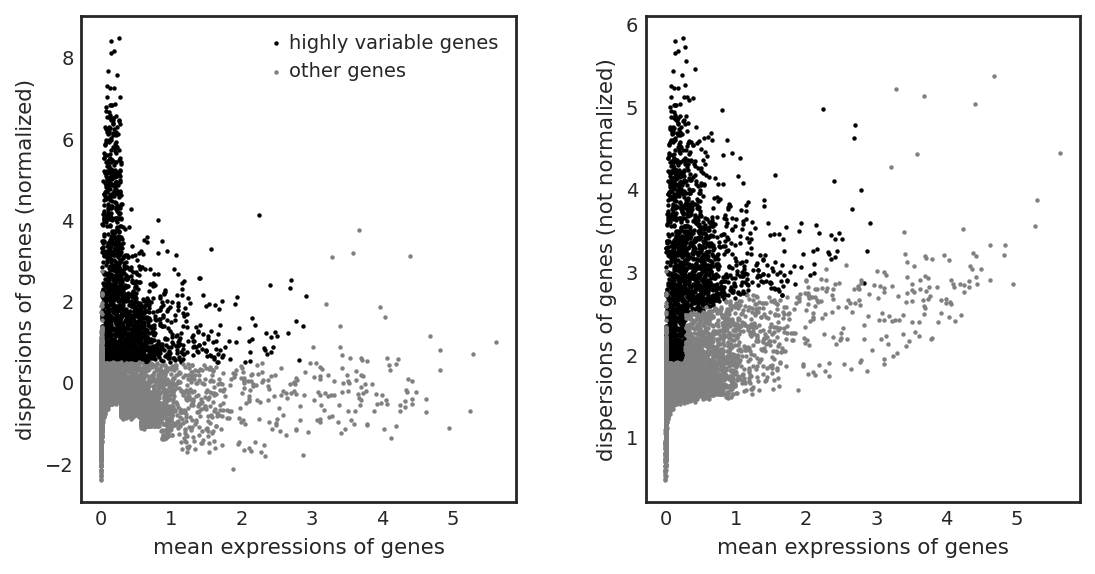

LOG MESSAGE: After feature selection of highly variable genes: 2504 cells, 1719 genes
LOG MESSAGE: 	Time for feature selection: 2.452s


In [29]:
adata = bc.st.highly_variable_genes(adata)

### Regression steps, and output of regressed data ###

In [30]:
adata 

View of AnnData object with n_obs × n_vars = 2504 × 1719 
    obs: 'CELL', 'percent_mito', 'experiment', 'n_counts', 'n_genes'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells', 'total_counts', 'frac_reads'
    uns: 'experiment_colors', 'log1p'

In [31]:
# RMK : AS OF FEB 2020 there is a bug in scanpy regress out if scanpy installed with PIP (see https://github.com/theislab/scanpy/issues/707)
# Before the fix is available, one should coopy the data toprevet it. hence the adata = adata.copy()
adata = adata.copy()
adata = bc.st.regress_out(adata, results_folder)

LOG MESSAGE: Regression steps completed. 'n_counts' and 'percent_mito' regressed out. adata was log-normalized and scaled.
LOG MESSAGE: 	Time for regression steps: 5.915s


'n_counts' and 'percent_mito' regressed out
adata scaled with max_value set to 10


### PCA-based neighborhood analysis and UMAP with optional batch correction

We use the Batch Balanced K-Nearest Neighbourhood (bbknn, [Teichlab/bbknn](https://github.com/Teichlab/bbknn)) method as the batch correction method.

Using random_state = 0 for all the following calculations
PCA calculated using svd_solver = 'arpack'. PCA multiplied by -1 to match Seurat output.


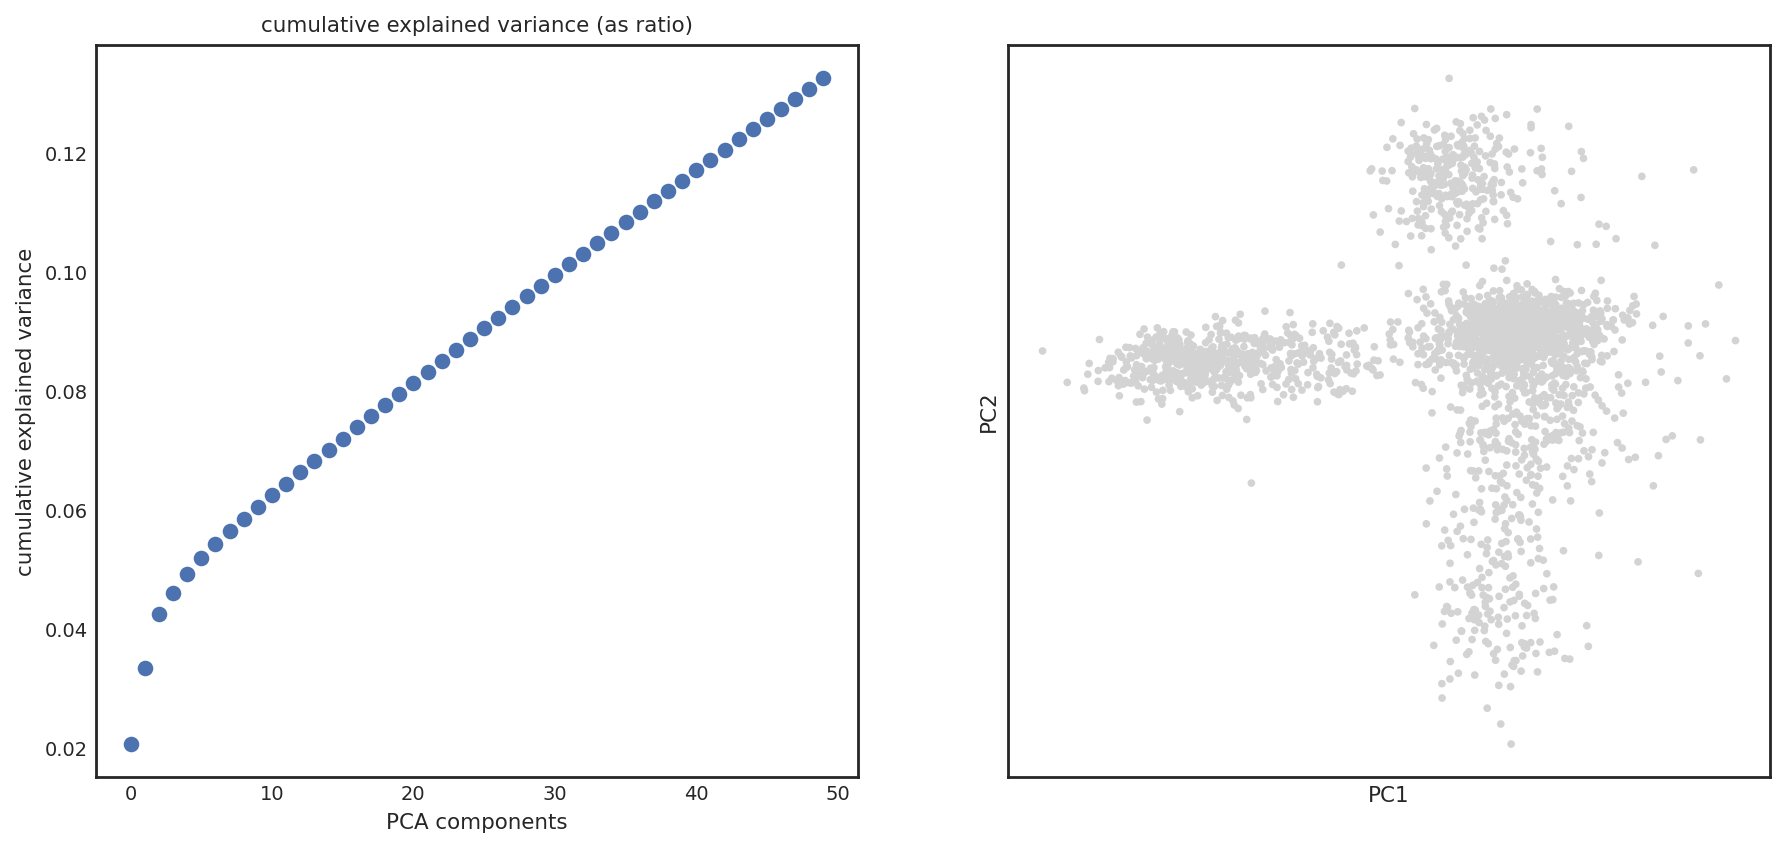

Nearest neighbors calculated with n_neighbors = 10


LOG MESSAGE: Neighborhood analysis completed, and UMAP generated.
LOG MESSAGE: 	 Time for PCA, nearest neighbor calculation and UMAP generation: 10.363s
LOG MESSAGE: Metadata containing 3 PCAs and UMAP coordinates exported successfully to file.
LOG MESSAGE: Time for export: 0.051s


UMAP coordinates calculated.
results successfully written out to 'analysis_metadata.tsv'


In [32]:
if (batch_to_correct != 'None'):
    #save a copy of uncorrected in case we need it for something later
    adata_uncorrected = adata.copy()
    adata.obs['batch'] = adata.obs[batch_to_correct]
    adata = bc.st.pca_neighbors_umap(adata,results_folder, method='bbknn')
else:
    adata = bc.st.pca_neighbors_umap(adata, results_folder)
    

### Clustering


Here the resolution was increased to increase the number of cluster.
In particular, based on the annotation notebook, with  lower resolution (default is 1) we obtained mixed clusters (T cells and N kcells). 

With an increased resolution (myres=1.4) such mix  cluster is divided.
Additional division might be need to split our CD8 and CD4 T cells based on anntation.
We fixed the current resolution to 1.5 which seems a good compromise.
Here the standard workflow and the annotation workbooks were done in a iterative process.

leiden clustering performed with a resolution of 1.5


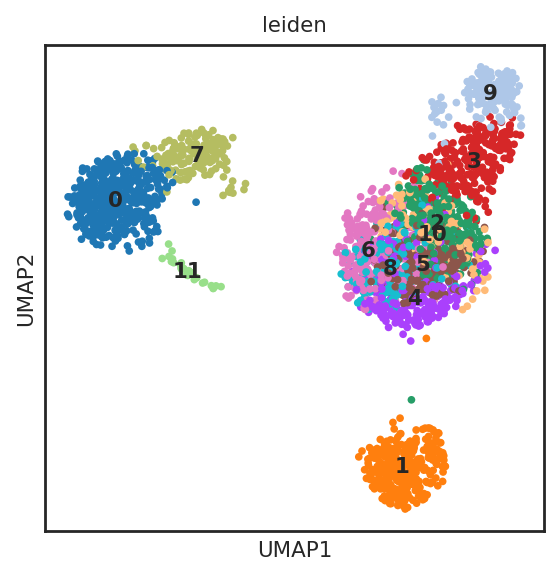

LOG MESSAGE: leidenclustering done. Found 12 clusters.
LOG MESSAGE: 	Time for leiden clustering: 0.831s
LOG MESSAGE: Marker gene detection performed on a per-cluster basis using the method wilcoxon.
LOG MESSAGE: 	Time for marker gene detection: 2.353s


rank genes per cluster calculated using method wilcoxon.
mapping of cells to  leiden exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out
./analyzed/pbmc3k_filtered/labelings/leiden/WilxRank.gct written out
./analyzed/pbmc3k_filtered/labelings/leiden/WilxRank.pvalues.gct written out


LOG MESSAGE: Cluster level analysis and marker genes exported to file.
LOG MESSAGE: 	Time for export of cluster level analysis: 1.909s


./analyzed/pbmc3k_filtered/labelings/leiden/WilxRank.logFC.gct written out


In [33]:
 
adata = bc.st.clustering(adata, results_folder, myres=1.5)

In [34]:
# everything that was done so far goes to the .h5ad file for later use
adata.write(results_file)
print(results_file)

./analyzed/pbmc3k_filtered/pbmc3k_filtered.h5ad


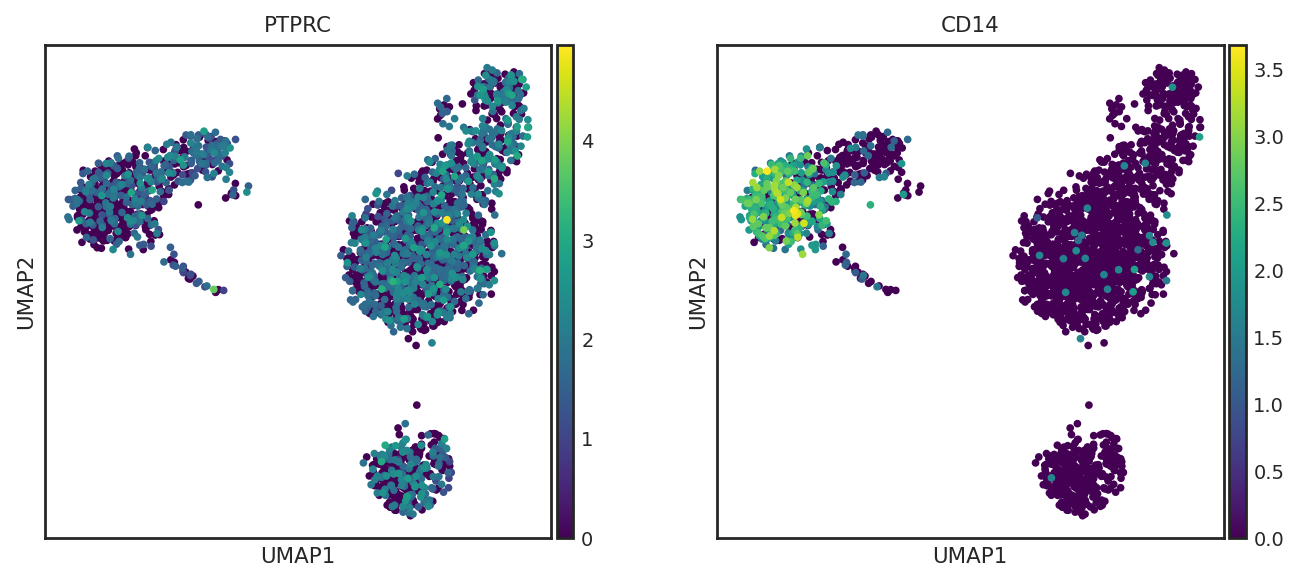

In [35]:
sc.pl.umap( adata, color=['PTPRC', 'CD14'], color_map = 'viridis')

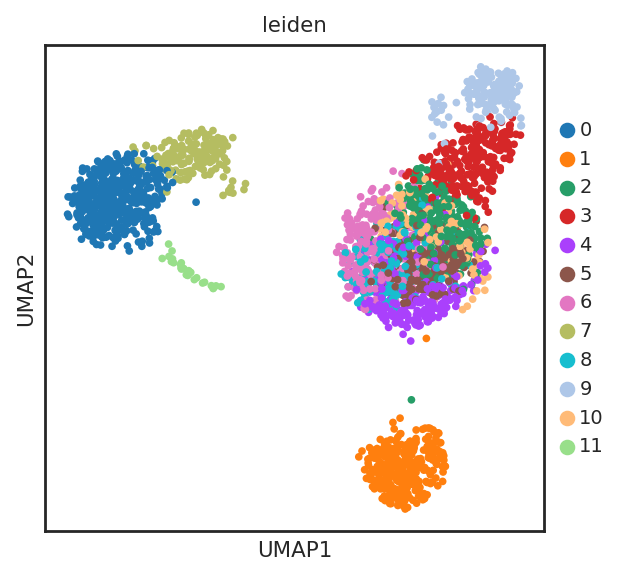

In [36]:
sc.pl.umap( adata, color='leiden', color_map = 'viridis')

### Additional Labeling ###

If `labeling_to_use` is specified, additional labels are taken from annotations in "metadata.tsv", and the data associated with additional labelling will be exported to files. And the fract_pos.gct and average.gct files are generated.

In [37]:
if (labeling_to_use != 'None'):
    adata = bc.st.additional_labeling(adata, labeling_to_use, labeling_name, labeling_description, labeling_author, results_folder)

### Complete the log-file

In [38]:
logging.info('Entire workflow completed.')
logging.info('\tTime for entire workflow: '+str(round(time.time()-start0, 3))+'s')

LOG MESSAGE: Entire workflow completed.
LOG MESSAGE: 	Time for entire workflow: 44.935s


### Write QC Report

In [39]:
bc.st.write_qc(adata_unfiltered = adata_unfiltered, 
                 adata_filtered = adata,
                 version = version, 
                 analysis_name = analysis_name, 
                 standard_min_genes = standard_min_genes, 
                 standard_min_cells = standard_min_cells, 
                 standard_min_counts = standard_min_counts, 
                 standard_percent_mito = standard_percent_mito, 
                 standard_max_counts = standard_max_counts,
                 standard_n_genes = standard_n_genes,
                 filtering_output1 = filtering1,
                 filtering_output2 = filtering2,
                 results_folder = results_folder,
                 css_path = os.path.join(os.path.dirname(bc.__file__),'st', 'style.css'))
logging.info('QC Report generated and saved as .html')

LOG MESSAGE: QC Report generated and saved as .html


### Session info

Finally, we report the session info with the package [sinfo](https://gitlab.com/joelostblom/sinfo).

In [40]:
from sinfo import sinfo

sinfo()

-----
anndata     NA
besca       0+untagged.185.gde1fdd3.dirty
matplotlib  3.2.1
numpy       1.17.0
pandas      1.0.3
scanpy      1.4.6
scipy       1.4.1
seaborn     0.10.1
sinfo       0.3.1
-----
IPython             7.14.0
jupyter_client      6.1.3
jupyter_core        4.6.3
notebook            6.0.3
-----
Python 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) [GCC 7.3.0]
Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-centos-7.4.1708-Core
24 logical CPU cores, x86_64
-----
Session information updated at 2020-06-02 09:48
